![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-ocr-workshop/blob/master/tutorials/Certification_Trainings_JSL/2.2.Spark_OCR_training_Table_recognition.ipynb)


# Spark-ocr demo for table recognition and free text extraction

The aim of this notebook is to show Spark-OCR abilities for 
* Table recognition
* Free-text extraction

## Set up environment

### Colab Setup

In [1]:
# Install the johnsnowlabs library to access Spark-OCR and Spark-NLP for Healthcare, Finance, and Legal.
!pip install -q johnsnowlabs

You should consider upgrading via the '/usr/bin/python3.7 -m pip install --upgrade pip' command.


In [ ]:
from google.colab import files
print('Please Upload your John Snow Labs License using the button below')
license_keys = files.upload()

In [2]:
from johnsnowlabs import nlp, visual

# After uploading your license run this to install all licensed Python Wheels and pre-download Jars the Spark Session JVM
nlp.install()

🚨 Spark-Healthcare installation seems broken, there was an exception while importing it. It will not be available on the jsl.xx module
You can run  jsl.install(refresh_install=True, force_browser=True)  to re-install latest version. 
🚨 Enterprise Finance installation seems broken, there was an exception while importing it. It will not be available on the jsl.xx module
You can run  jsl.install(refresh_install=True, force_browser=True)  to re-install latest version. 
🚨 Enterprise Finance installation seems broken, there was an exception while importing it. It will not be available on the jsl.xx module
You can run  jsl.install(refresh_install=True, force_browser=True)  to re-install latest version. 
🚨 Outdated Medical Secrets in license file. Version=4.2.2 but should be Version=4.2.4
📋 Loading license number 0 from /home/jose/.johnsnowlabs/licenses/license_number_0_for_Spark-Healthcare_Spark-OCR.json
👌 JSL-Home is up to date! 
👌 Everything is already installed, no changes made


In [3]:
import pkg_resources

from pyspark.ml import PipelineModel
from pyspark.sql import functions as F

## Run Spark-ocr

In [4]:
from johnsnowlabs import nlp, visual
import pandas as pd

# Automatically load license data and start a session with all jars user has access to
spark = nlp.start(visual=True)

👌 Launched cpu optimized session with with: 🚀Spark-NLP==4.2.4, 💊Spark-Healthcare==4.2.4, 🕶Spark-OCR==4.2.4, running on ⚡ PySpark==3.1.2


### Load sample

In [8]:
from pyspark.ml import PipelineModel

imagePath = "/content/cTDaR_t10096.jpg"

df = spark.read.format("binaryFile").load(imagePath)
df.show()

+--------------------+--------------------+------+--------------------+
|                path|    modificationTime|length|             content|
+--------------------+--------------------+------+--------------------+
|file:/home/jose/s...|2023-01-17 10:30:...|385071|[FF D8 FF E0 00 1...|
+--------------------+--------------------+------+--------------------+




### What if no table recognition?

In [9]:
binary_to_image = BinaryToImage()
binary_to_image.setOutputCol("image")
binary_to_image.setImageType(ImageType.TYPE_3BYTE_BGR)

ocr = ImageToText()
ocr.setInputCol("image")
ocr.setOutputCol("text")
ocr.setOcrParams(["preserve_interword_spaces=1", ])
ocr.setOutputSpaceCharacterWidth(10)

pipeline_ocr = PipelineModel(stages=[
    binary_to_image,
    ocr
])

result = pipeline_ocr.transform(df).cache()
print("\n".join([row.text for row in result.select("text").collect()]))

 

HISTORY, DEVELOPMENT AND CORPORATE STRUCTURE

 

(iii) Series B Financing

On April 28, 2018, the Company and its subsidiaries entered into the Series B Share
Purchase Agreement with the then Series B Preferred Shareholders, pursuant to which the then
Series B Preferred Shareholders agreed to subscribe for a maximum of 45,908,818 Series B
Preferred Shares in aggregate to be issued by our Company at a subscription price of
approximately US$5.66 per share and an aggregate consideration of approximately US$260
million. The Series B Preferred Shares were issued in full on May 8, 2018 as set forth in the
table below.

 

Number of
Series B            Purchase
Name of Shareholder                         Preferred Shares            Amount
(US$)
WuXi Healthcare Ventures                              882,861        4,999,994.99
6 Dimensions Capital, L.P.                             3,354,875       18,999,999.08
6 Dimensions Affiliates Fund, L.P.                       176,572         999,997.8


### Table data extraction

In [10]:
binary_to_image = visual.BinaryToImage()
binary_to_image.setOutputCol("image")
binary_to_image.setImageType(visual.ImageType.TYPE_3BYTE_BGR)

# Detect tables on the page using pretrained model
# It can be finetuned for have more accurate results for more specific documents
table_detector = visual.ImageTableDetector.pretrained("general_model_table_detection_v2", "en", "clinical/ocr")
table_detector.setInputCol("image")
table_detector.setOutputCol("region")

# Draw detected region's with table to the page
draw_regions = visual.ImageDrawRegions()
draw_regions.setInputCol("image")
draw_regions.setInputRegionsCol("region")
draw_regions.setOutputCol("image_with_regions")
draw_regions.setRectColor(Color.red)

# Extract table regions to separate images
splitter = visual.ImageSplitRegions()
splitter.setInputCol("image")
splitter.setInputRegionsCol("region")
splitter.setOutputCol("table_image")
splitter.setDropCols("image")

# Detect cells on the table image
cell_detector = visual.ImageTableCellDetector()
cell_detector.setInputCol("table_image")
cell_detector.setOutputCol("cells")
cell_detector.setAlgoType("morphops")
cell_detector.setDrawDetectedLines(True)

# Extract text from the detected cells 
table_recognition = visual.ImageCellsToTextTable()
table_recognition.setInputCol("table_image")
table_recognition.setCellsCol('cells')
table_recognition.setMargin(3)
table_recognition.setStrip(True)
table_recognition.setOutputCol('table')

# Erase detected table regions
fill_regions = visual.ImageDrawRegions()
fill_regions.setInputCol("image")
fill_regions.setInputRegionsCol("region")
fill_regions.setOutputCol("image_1")
fill_regions.setRectColor(Color.white)
fill_regions.setFilledRect(True)

# OCR
ocr = visual.ImageToText()
ocr.setInputCol("image_1")
ocr.setOutputCol("text")
ocr.setOcrParams(["preserve_interword_spaces=1", ])
ocr.setKeepLayout(True)
ocr.setOutputSpaceCharacterWidth(8)

pipeline_table = PipelineModel(stages=[
    binary_to_image,
    table_detector,
    draw_regions,
    fill_regions,
    splitter,
    cell_detector,
    table_recognition,
    ocr
])

tables_results = pipeline_table.transform(df).cache()

general_model_table_detection_v2 download started this may take some time.
Approximate size to download 264.7 MB


In [11]:
tables_results.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------+-------+--------------------+--------------------+--------------------+--------------------+-----------------+---------+--------------------+--------------------+
|         table_image|              region|               image|    modificationTime|             image_1|                path|length|pagenum|  image_with_regions|               cells|        output_image|               table|       confidence|exception|                text|           positions|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------+-------+--------------------+--------------------+--------------------+--------------------+-----------------+---------+--------------------+--------------------+
|{file:/home/jose/...|{0, 0, 214.0, 437...|{file:/home/jose/...|2023-01-17 10:30:...|{file:/home/jose/...|fil


    Image #0:
    Origin: file:/home/jose/spark-ocr/workshop/tutorials/Certification_Trainings/content/cTDaR_t10096.jpg
    Resolution: 0 dpi
    Width: 1190 px
    Height: 1588 px
    Mode: ImageType.TYPE_3BYTE_BGR
    Number of channels: 3


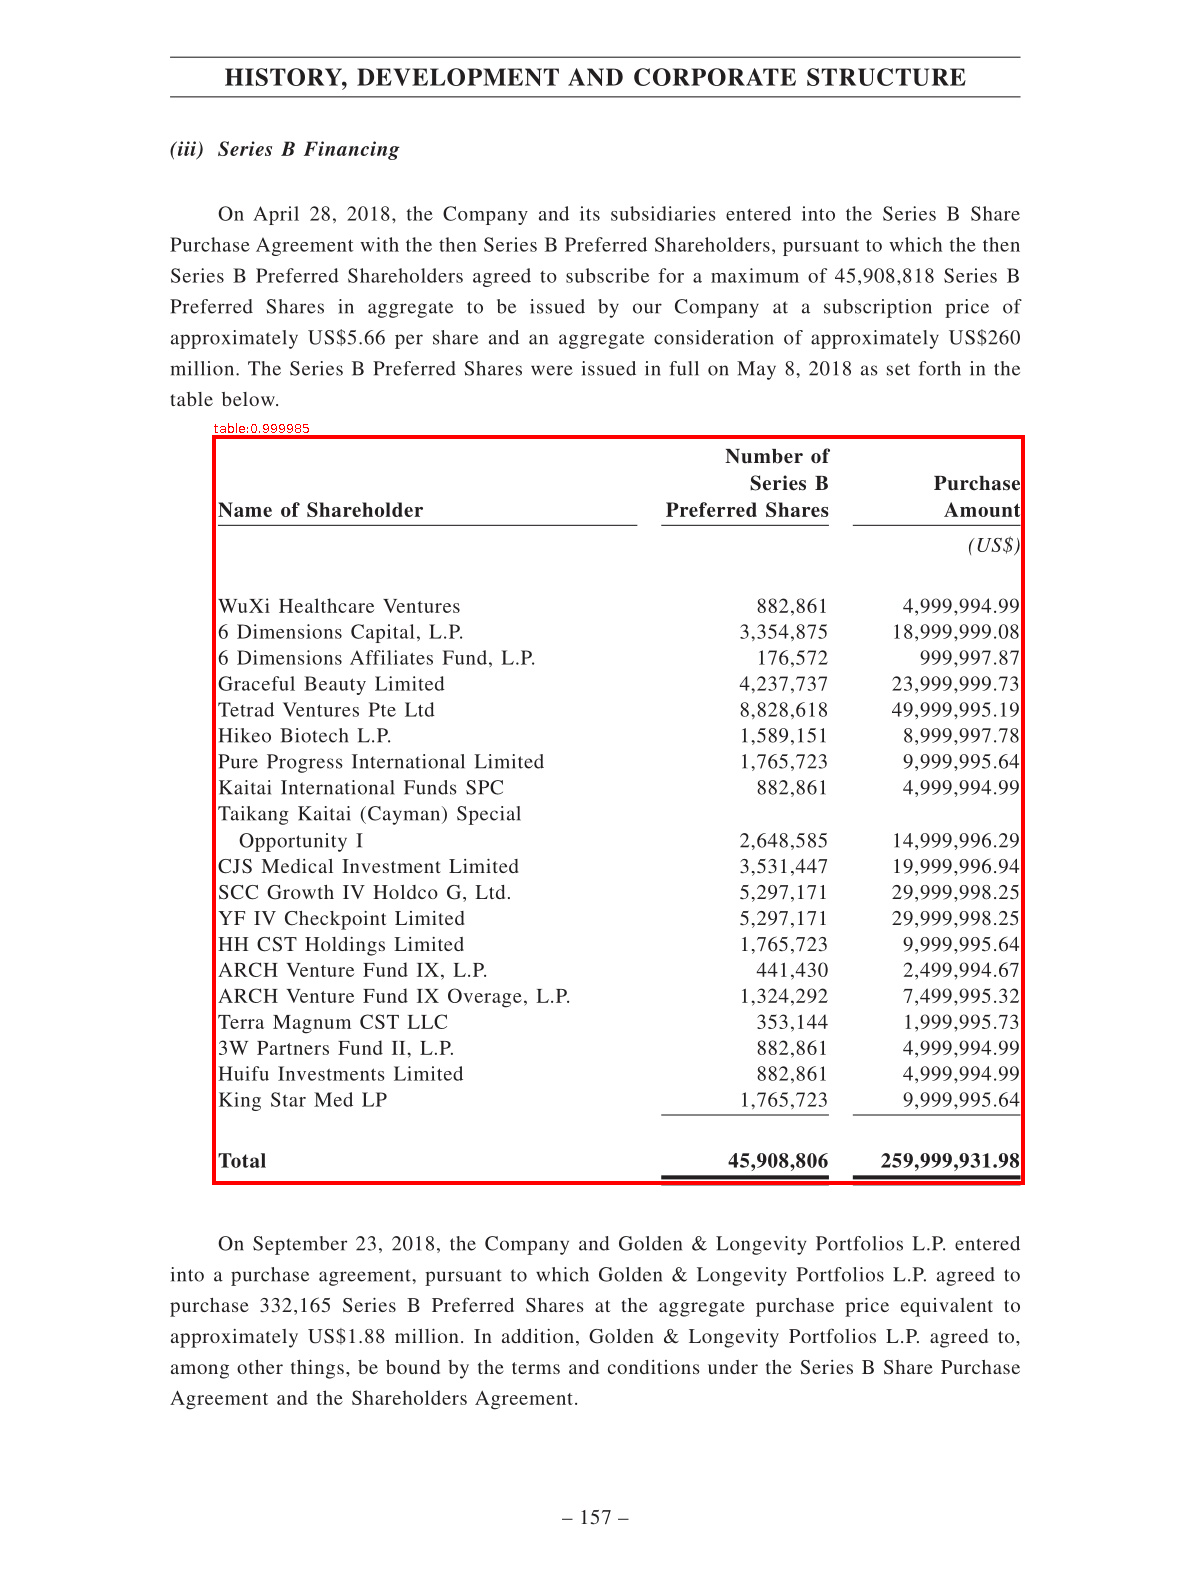

CPU times: user 171 ms, sys: 28.9 ms, total: 200 ms
Wall time: 352 ms


In [12]:
%%time
visual.display_images(tables_results, "image_with_regions")

## Tables

In [13]:
visual.display_tables(tables_results)

Filename: cTDaR_t10096.jpg
Page:     0
Table:    0


,col0,col1,col2
0,,Number of,
1,,Series B,Purchase
2,Name of Shareholder,Preferred Shares,Amount
3,,,(US$)
4,WuXi Healthcare Ventures,882. 861,4.999.994.99
5,"6 Dimensions Capital, L.P.",3 AS48375,"18,999.999.08"
6,"6 Dimensions Affiliates Fund, L.P.",176.572,999 997.87
7,Graceful Beauty Limited,4.937.737,"23.999 _.999,73"
8,Tetrad Ventures Pte Ltd,8.828.618,49.999 .995.19
9,Hikeo Biotech L.P.,"1,589,151","8,999.997.78"


## Free text

In [14]:
tables_results.select("text").show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## Processing of PDF


In [15]:
!gdown 1AhAKlyxX_PEWI9bI0M0KH0wgzrKOpLTt

Downloading...
From: https://drive.google.com/uc?id=1AhAKlyxX_PEWI9bI0M0KH0wgzrKOpLTt
To: /home/jose/spark-ocr/workshop/tutorials/Certification_Trainings/budget.pdf
100%|████████████████████████████████████████| 339k/339k [00:00<00:00, 2.70MB/s]


In [16]:
pdfPath = "/content/budget.pdf"

pdf_df = spark.read.format("binaryFile").load(pdfPath)

pdf_to_image = visual.PdfToImage() \
    .setInputCol("content") \
    .setOutputCol("image") \
    .setImageType(ImageType.TYPE_3BYTE_BGR) \
    .setKeepInput(True)

pipeline_table_pdf = PipelineModel(stages=[
    pdf_to_image,
    table_detector,
    draw_regions,
    fill_regions,
    splitter,
    cell_detector,
    table_recognition,
    ocr
])

tables_results_pdf = pipeline_table_pdf.transform(pdf_df).cache()


    Image #0:
    Origin: file:/home/jose/spark-ocr/workshop/tutorials/Certification_Trainings/budget.pdf
    Resolution: 0 dpi
    Width: 3507 px
    Height: 2480 px
    Mode: ImageType.TYPE_3BYTE_BGR
    Number of channels: 3


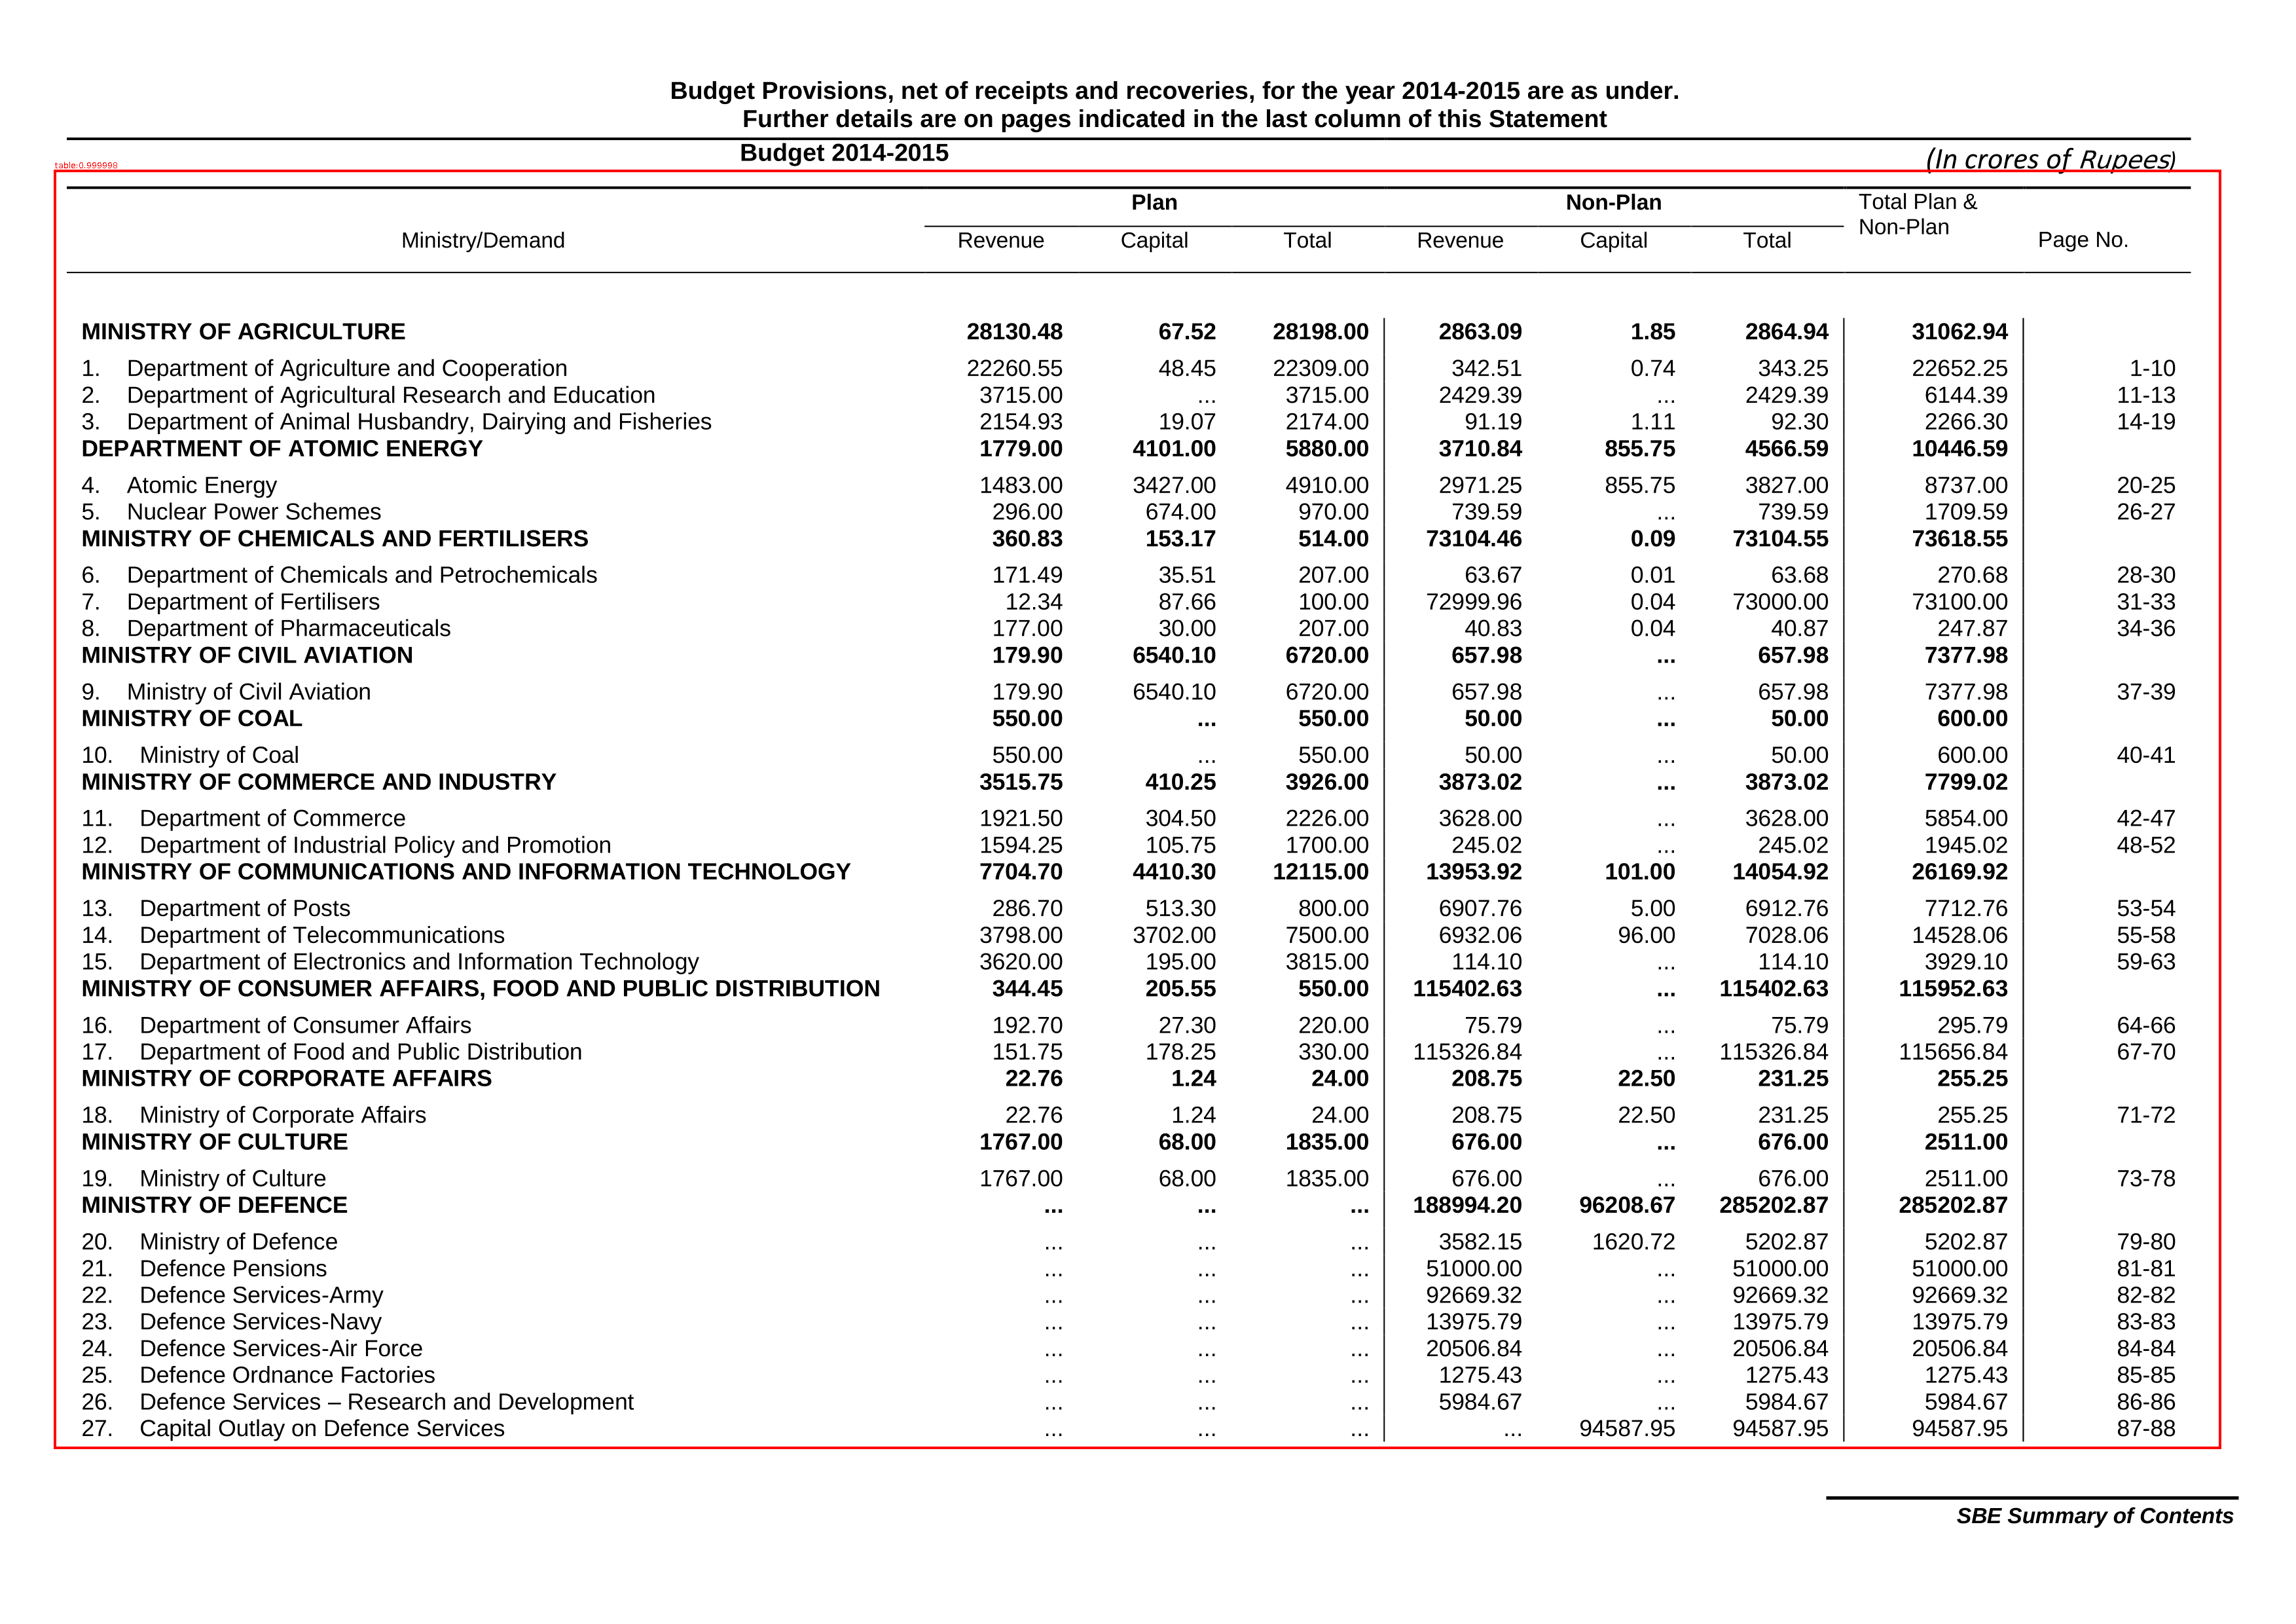

CPU times: user 381 ms, sys: 105 ms, total: 486 ms
Wall time: 739 ms


In [21]:
%%time
visual.display_images(tables_results_pdf, "image_with_regions")

Table extracted from pdf

In [22]:
visual.display_tables(tables_results_pdf)

Filename: budget.pdf
Page:     0
Table:    0


,col0,col1,col2,col3,col4,col5,col6,col7,col8
0,,,Plan,,,Non-Plan,,Total Plan &,
1,Ministry/Demand,Revenue,Capital,Total,Revenue,Capital,Total,Non-Plan Pz,ge No.
2,MINISTRY OF AGRICULTURE,28130.48,67.52,28198.00,2863.09,1.85,2864.94,31062.94,
3,1. Department of Agriculture and Cooperation,22260.55,48.45,22309.00,349 51,0.74,343.25,92652.25,1-10
4,2. Department of Aaricultural Research and Edu...,3715.00,,3715.00,2429.39,,2429.39,6144.39,11-13
5,3. PDevnartment of Animal Husbandry. Dairving ...,2154.93,19.07,2174.00,91.19,1.11,9? 30,2266.30,14-19
6,DEPARTMENT OF ATOMIC ENERGY,1779.00,4101.00,5880.00,3710.84,855.75,4566.59,10446.59,
7,4. Atomic Eneray,1483.00,3427.00,4910.00,2971.25,855.75,3827.00,8737.00,20-25
8,5. Nuclear Power Schemes,296.00,674.00,970.00,739 59,,739 59,1709.59,26-27
9,MINISTRY OF CHEMICALS AND FERTILISERS,360.83,153.17,514.00,73104.46,0.09,73104.55,73618.55,
